# Exploratory Data Analysis (King County Housing)

## 1. Loading the libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import rmse
import arviz as az
import stan

%matplotlib inline

## 2. Reading in the data

In [5]:
housing = pd.read_csv('data/King_County_House_prices_dataset.csv')

## 3. Exploring the variables and values

In [6]:
housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [7]:
# What datatypes are there?
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [8]:
# What variables are non continuous?
housing.nunique()

id               21420
date               372
price             3622
bedrooms            12
bathrooms           29
sqft_living       1034
sqft_lot          9776
floors               6
waterfront           2
view                 5
condition            5
grade               11
sqft_above         942
sqft_basement      304
yr_built           116
yr_renovated        70
zipcode             70
lat               5033
long               751
sqft_living15      777
sqft_lot15        8682
dtype: int64

Low-count variables: bedrooms, bathrooms, floors, view
Binary: waterfront
Categorical (ordinal): condition, grade 
Categorical (unordered/not linearly ordered):  

## 5. Data Cleaning

In [9]:
# one house apperently had 33 bedrooms but only 1.75 bathrooms
housing.bedrooms.replace(33, np.nan, inplace=True)
# one house apperently was build in the birth year of Christ
housing.yr_renovated.replace(np.NaN, 0, inplace=True)

In [10]:
housing.sqft_basement.replace('?', 0, inplace=True)
housing.sqft_basement = pd.Series(housing.sqft_basement, dtype='float64')

## 5. Formatting the variables

Setting the date in the correct format

In [11]:
housing.date = pd.to_datetime(housing.date)
# checking for irregularities
print(housing.date.min() , ' to ' , housing.date.max())

2014-05-02 00:00:00  to  2015-05-27 00:00:00


## Taking a detour: Did the house prices rise? (price per squarefeet living area) 

In [12]:
housing['date_days'] = housing.date - housing.date.min()
housing['date_days'] = housing.date_days / np.timedelta64(1, 'D')

In [13]:
housing['price_sqft'] = housing.price / housing.sqft_living

<AxesSubplot:xlabel='date_days', ylabel='price_sqft'>

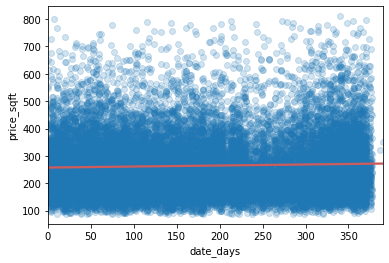

In [39]:
sns.regplot(data=housing, x='date_days', y= 'price_sqft', scatter_kws={'alpha': 0.2}, line_kws={'color':'indianred'} )

In [41]:
price_date = housing[['price_sqft', 'date_days']].dropna(axis=0)
sm.OLS(price_date.price_sqft, sm.add_constant(price_date.date_days) ).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_sqft   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     31.89
Date:                Sat, 05 Jun 2021   Prob (F-statistic):           1.65e-08
Time:                        14:53:58   Log-Likelihood:            -1.3214e+05
No. Observations:               21597   AIC:                         2.643e+05
Df Residuals:                   21595   BIC:                         2.643e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        257.4115      1.407    182.913      0.000     254.653     260.170
date_days      0.0374      0.007      5.647      0.000       0.024       0.050
==============================================================================
Omnibus:                     4525.228   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9389.081
Skew:                           1.239   Prob(JB):                         0.00
Kurtosis:                       5.072   Cond. No.                         400.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

In [46]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta * X

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)


You can find the C code in this temporary file: /tmp/theano_compilation_error_0e4gzixu


Exception: ("Compilation failed (return status=1): /usr/bin/ld: /home/mario/.pyenv/versions/3.8.5/lib/libpython3.8.a(pythonrun.o): warning: relocation against `_Py_UnhandledKeyboardInterrupt' in read-only section `.text'. /usr/bin/ld: /home/mario/.pyenv/versions/3.8.5/lib/libpython3.8.a(dictobject.o): relocation R_X86_64_PC32 against symbol `PyUnicode_Type' can not be used when making a shared object; recompile with -fPIC. /usr/bin/ld: final link failed: bad value. collect2: error: ld returned 1 exit status. ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{0.01}))')

In [ ]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate